In [1]:
# orbit - Program to compute the orbit of a comet.

# Set up configuration options and special features
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def gravrk(s,t,GM):
    #  Returns right-hand side of Kepler ODE; used by Runge-Kutta routines
    #  Inputs
    #    s      State vector [r(1) r(2) v(1) v(2)]
    #    t      Time (not used)
    #    GM     Parameter G*M (gravitational const. * solar mass)
    #  Output
    #    deriv  Derivatives [dr(1)/dt dr(2)/dt dv(1)/dt dv(2)/dt]

    #* Compute acceleration
    r = np.array([s[0], s[1]])  # Unravel the vector s into position and velocity
    v = np.array([s[2], s[3]])
    accel = -GM*r/np.linalg.norm(r)**3    # Gravitational acceleration

    #* Return derivatives [dr(1)/dt dr(2)/dt dv(1)/dt dv(2)/dt]
    deriv = np.array([v[0], v[1], accel[0], accel[1]])
    return deriv

In [3]:
def rk4(x,t,tau,derivsRK,param):
    #  Runge-Kutta integrator (4th order)
    # Input arguments -
    #   x = current value of dependent variable
    #   t = independent variable (usually time)
    #   tau = step size (usually timestep)
    #   derivsRK = right hand side of the ODE; derivsRK is the
    #             name of the function which returns dx/dt
    #             Calling format derivsRK (x,t,param).
    #   param = extra parameters passed to derivsRK
    # Output arguments -
    #   xout = new value of x after a step of size tau
    
    half_tau = 0.5*tau
    F1 = derivsRK(x,t,param)  
    t_half = t + half_tau
    xtemp = x + half_tau*F1
    F2 = derivsRK(xtemp,t_half,param)  
    xtemp = x + half_tau*F2
    F3 = derivsRK(xtemp,t_half,param)
    t_full = t + tau
    xtemp = x + tau*F3
    F4 = derivsRK(xtemp,t_full,param)
    xout = x + tau/6.*(F1 + F4 + 2.*(F2+F3))
    return xout

In [4]:
def rka(x,t,tau,err,derivsRK,param):
    # Adaptive Runge-Kutta routine
    # Inputs
    #   x          Current value of the dependent variable
    #   t          Independent variable (usually time)
    #   tau        Step size (usually time step)
    #   err        Desired fractional local truncation error
    #   derivsRK   Right hand side of the ODE; derivsRK is the
    #              name of the function which returns dx/dt
    #              Calling format derivsRK (x,t,param).
    #   param      Extra parameters passed to derivsRK
    # Outputs
    #   xSmall     New value of the dependent variable
    #   t          New value of the independent variable
    #   tau        Suggested step size for next call to rka

    #* Set initial variables
    tSave, xSave = t, x        # Save initial values
    safe1, safe2 = 0.9, 4.0    # Safety factors
    eps = 1.e-15

    #* Loop over maximum number of attempts to satisfy error bound
    xTemp = np.empty(len(x))
    xSmall = np.empty(len(x)); xBig = np.empty(len(x))
    maxTry = 100
    for iTry in range(maxTry):

        #* Take the two small time steps
        half_tau = 0.5 * tau
        xTemp = rk4(xSave,tSave,half_tau,derivsRK,param)
        t = tSave + half_tau
        xSmall = rk4(xTemp,t,half_tau,derivsRK,param)
  
        #* Take the single big time step
        t = tSave + tau
        xBig = rk4(xSave,tSave,tau,derivsRK,param)
  
        #* Compute the estimated truncation error
        scale = err * (abs(xSmall) + abs(xBig))/2.
        xDiff = xSmall - xBig
        errorRatio = np.max( np.absolute(xDiff) / (scale + eps) )
  
        #* Estimate new tau value (including safety factors)
        tau_old = tau
        tau = safe1*tau_old*errorRatio**(-0.20)
        tau = max(tau, tau_old/safe2)
        tau = min(tau, safe2*tau_old)
  
        #* If error is acceptable, return computed values
        if errorRatio < 1 :
            return np.array([xSmall, t, tau]) 

    #* Issue error message if error bound never satisfied
    print 'ERROR: Adaptive Runge-Kutta routine failed'
    return np.array([xSmall, t, tau])

In [5]:
#* Set initial position and velocity of the comet.
r0 = input('Enter initial radial distance (AU): ')  
v0 = input('Enter initial tangential velocity (AU/yr): ')
r = np.array([r0, 0])
v = np.array([0, v0])
state = np.array([ r[0], r[1], v[0], v[1] ])   # Used by R-K routines

#* Set physical parameters (mass, G*M)
GM = 4 * np.pi**2      # Grav. const. * Mass of Sun (au^3/yr^2)
mass = 1.0             # Mass of comet 
adaptErr = 1.0e-3      # Error parameter used by adaptive Runge-Kutta
time = 0.0

Enter initial radial distance (AU): 1
Enter initial tangential velocity (AU/yr): 1.57


In [6]:
#* Loop over desired number of steps using specified
#  numerical method.
nStep = input('Enter number of steps: ')
tau = input('Enter time step (yr): ')
NumericalMethod = input(
    'Choose a numerical method: 1) Euler; 2) Euler-Cromer; 3) Runge-Kutta; 4) Adaptive R-K')
rplot = np.empty(nStep)           
thplot = np.empty(nStep)
tplot = np.empty(nStep)
kinetic = np.empty(nStep)
potential = np.empty(nStep)

for iStep in range(nStep):  

    #* Record position and energy for plotting.
    rplot[iStep] = np.linalg.norm(r)                # Record position for polar plot
    thplot[iStep] = np.arctan2(r[1],r[0])
    tplot[iStep] = time
    kinetic[iStep] = .5*mass*np.linalg.norm(v)**2   # Record energies
    potential[iStep] = - GM*mass/np.linalg.norm(r)
  
    #* Calculate new position and velocity using desired method.
    if NumericalMethod == 1 :
        accel = -GM*r/np.linalg.norm(r)**3   
        r = r + tau*v              # Euler step
        v = v + tau*accel  
        time = time + tau    
    elif NumericalMethod == 2 :
        accel = -GM*r/np.linalg.norm(r)**3   
        v = v + tau*accel 
        r = r + tau*v              # Euler-Cromer step
        time = time + tau     
    elif NumericalMethod == 3 :
         state = rk4(state,time,tau,gravrk,GM)
         r = [state[0], state[1]]   # 4th order Runge-Kutta
         v = [state[2], state[3]]
         time = time + tau   
    else : 
         [state, time, tau] = rka(state,time,tau,adaptErr,gravrk,GM);
         r = [state[0], state[1]]    # Adaptive Runge-Kutta
         v = [state[2], state[3]]

Enter number of steps: 40
Enter time step (yr): .1
Choose a numerical method: 1) Euler; 2) Euler-Cromer; 3) Runge-Kutta; 4) Adaptive R-K4


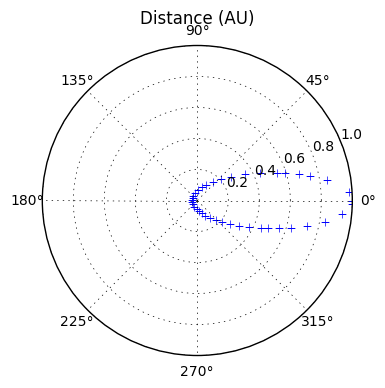

In [7]:
#* Graph the trajectory of the comet.
ax = plt.subplot(111, projection='polar')  # Use polar plot for graphing orbit
ax.plot(thplot,rplot,'+')  
ax.set_title('Distance (AU)')  
ax.grid(True)

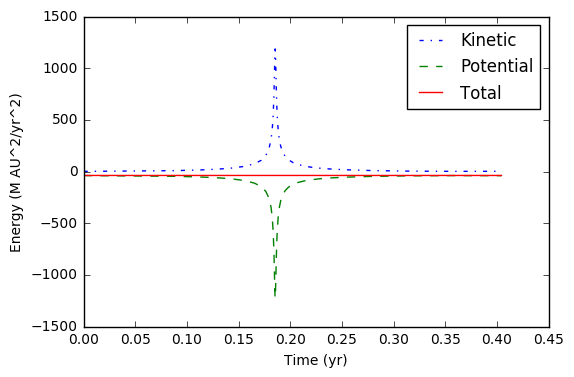

In [8]:
#* Graph the energy of the comet versus time.
totalE = kinetic + potential   # Total energy
plt.plot(tplot,kinetic,'-.',tplot,potential,'--',tplot,totalE,'-')
plt.legend(['Kinetic','Potential','Total']);
plt.xlabel('Time (yr)')
plt.ylabel('Energy (M AU^2/yr^2)')